# 291 Final Project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit
import emcee

# 1. Convert CSV to energy spectra

In [3]:
detA = pd.read_csv("./data/DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])
detB = pd.read_csv("./data/DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])
detC = pd.read_csv("./data/DetectorC.csv", header=None, names=["event_id", "class_score", "energy"])
detTarget = pd.read_csv("./data/DetectorTarget.csv", header=None, names=["event_id", "class_score", "energy"])

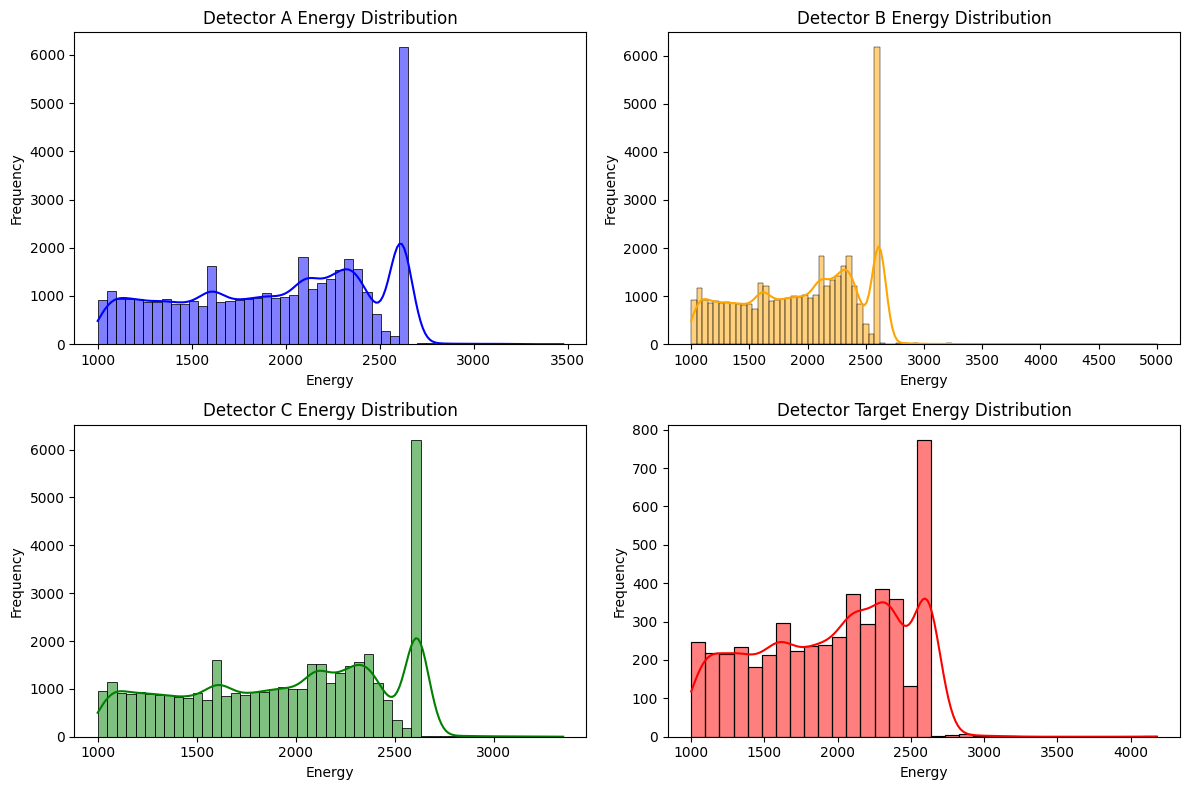

In [4]:
# plot histogram of energy for each detector
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(detA['energy'], kde=True, color='blue')
plt.title('Detector A Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.subplot(2, 2, 2)
sns.histplot(detB['energy'], kde=True, color='orange')
plt.title('Detector B Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.subplot(2, 2, 3)
sns.histplot(detC['energy'], kde=True, color='green')
plt.title('Detector C Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.subplot(2, 2, 4)
sns.histplot(detTarget['energy'], kde=True, color='red')
plt.title('Detector Target Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

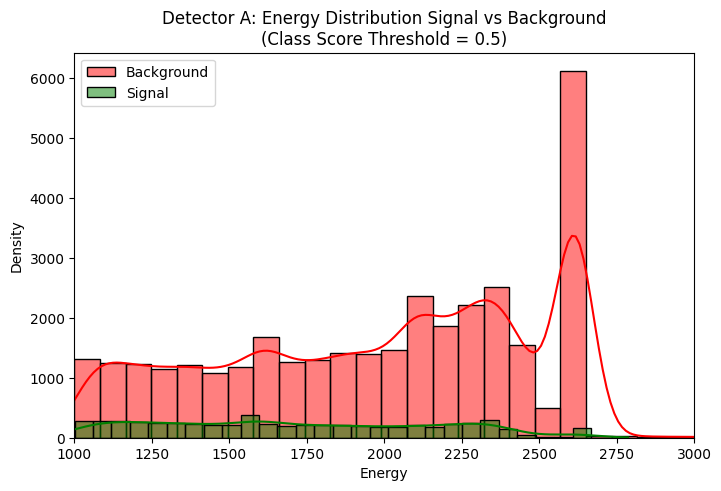

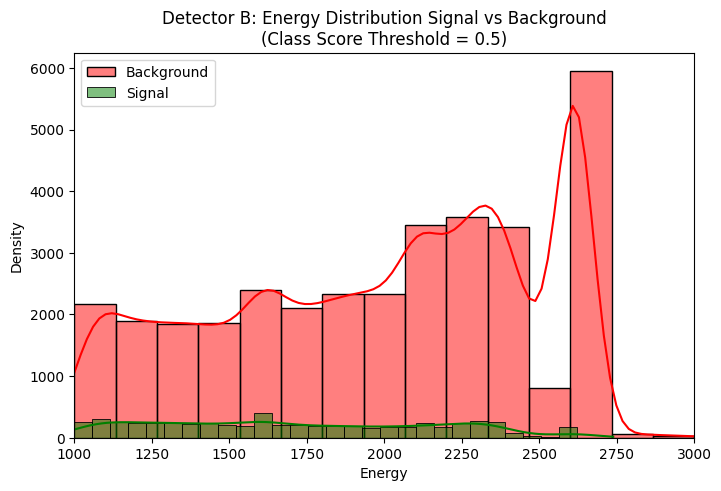

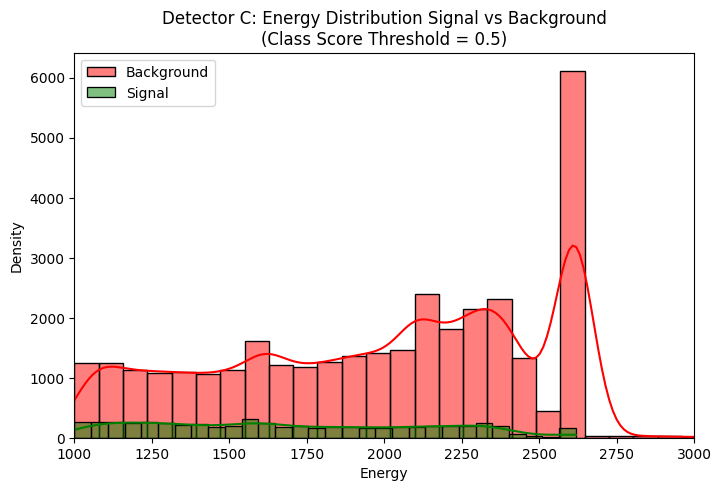

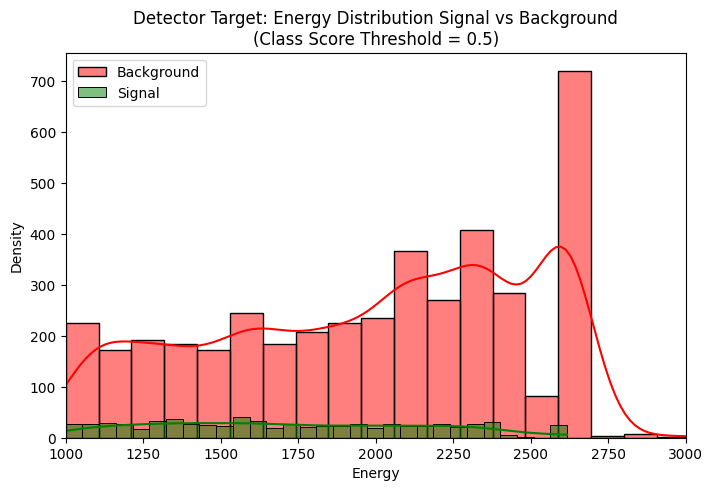

In [5]:
def split_plot(data, name, thresh=0.5, bins=30):
    detSignal = data[data['class_score'] > thresh]
    detBackground = data[data['class_score'] <= thresh]
    plt.figure(figsize=(8, 5))
    sns.histplot(detBackground['energy'], color='red', label='Background', kde=True, bins=bins)
    sns.histplot(detSignal['energy'], color='green', label='Signal', kde=True, bins=bins)
    plt.title(f'{name}: Energy Distribution Signal vs Background\n(Class Score Threshold = {thresh})')
    plt.xlabel('Energy')
    plt.xlim(1000, 3000)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

split_plot(detA, 'Detector A', 0.5)
split_plot(detB, 'Detector B', 0.5)
split_plot(detC, 'Detector C', 0.5)
split_plot(detTarget, 'Detector Target', 0.5)

# 2. Use 1592 keV peak in Detector A to set a cutting threshold

Evaluate true positive rate

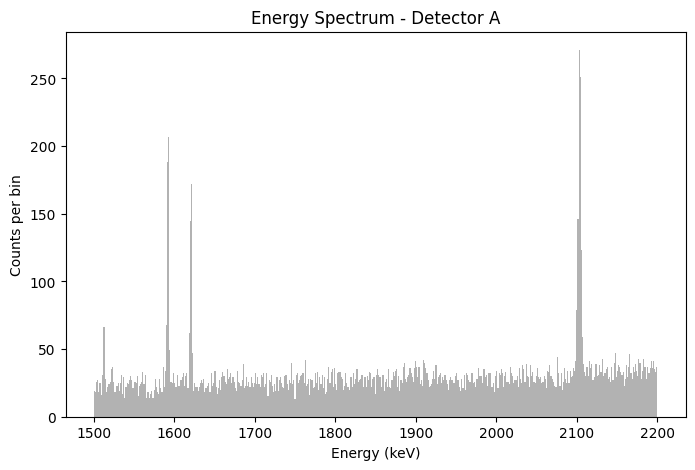

In [6]:
# Energy range for the spectrum (keV)
energy_min = 1500
energy_max = 2200
n_bins = 500  # adjust for resolution

# Histogram
counts, bin_edges = np.histogram(detA['energy'], bins=n_bins, range=(energy_min, energy_max))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, color='gray')
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Energy Spectrum - Detector A")
plt.show()

In [7]:
delta = 20
signal = 1592
background = 2103
A_signal = detA[(detA["energy"] >= signal - delta) & (detA["energy"] <= signal + delta)]
A_background = detA[(detA["energy"] >= background - delta) & (detA["energy"] <= background + delta)]

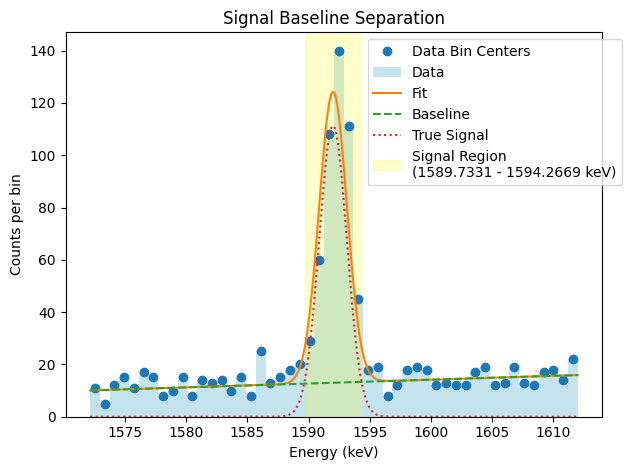

Fit results:
A = 139.56382222225528
mu = 1592.0
sigma = 1.1334474236858578
a = 16.289393676449897
b = 0.18488645067756196


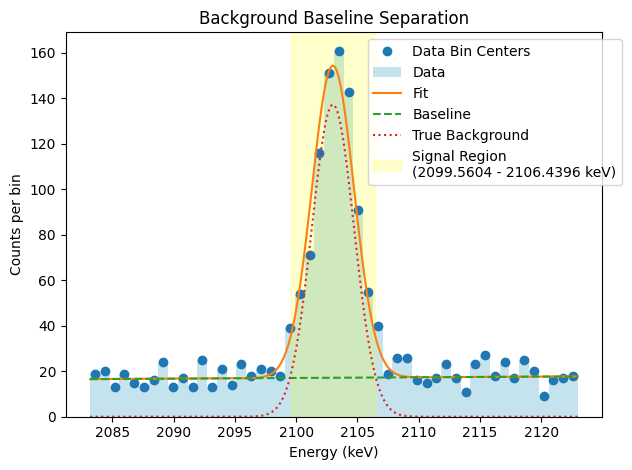

Fit results:
A = 172.4185014187384
mu = 2103.0
sigma = 1.7197990866196888
a = 21.52476658548735
b = 0.037850434368636575


In [8]:
def fit_signal_background(data, n_bins, mu, name):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    bin_width = (bin_edges[-1] - bin_edges[0]) / n_bins
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    def fit_function(x, A, mu, sigma, a, b):
        signal = A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        background = a + b * (x - mu)
        return signal + background

    # Define the chi-square function to minimize.
    def chi2(A, mu, sigma, a, b):
        expected = fit_function(bin_centers, A, mu, sigma, a, b) * bin_width
        mask = counts > 0
        return np.sum(((counts[mask] - expected[mask])**2) / counts[mask])
    
    # Implement the Minuit fitting below
    m = Minuit(chi2, A=np.max(counts) * bin_width, mu=mu, sigma=1, a=np.mean(counts) / bin_width, b=0)
    m.limits["A"] = (0, None)
    m.limits["sigma"] = (0, None)
    m.limits["a"] = (0, None)
    m.fixed["mu"] = True
    m.migrad()
    A_fit, mu_fit, sigma_fit, a_fit, b_fit = m.values["A", "mu", "sigma", "a", "b"]

    # Calculate Signal and Background counts in the signal region
    signal_region_min = mu_fit - 2 * sigma_fit
    signal_region_max = mu_fit + 2 * sigma_fit
    # signal_region = (bin_centers >= signal_region_min) & (bin_centers <= signal_region_max)

    # all_signals = np.sum(counts[signal_region])
    # backgrounds = np.sum(fit_function(bin_centers[signal_region], 0, mu_fit, sigma_fit, a_fit, b_fit) * bin_width)
    # signals = all_signals - backgrounds

    m_fine = np.linspace(min(data), max(data), 1000)
    plt.plot(bin_centers, counts, 'o', label='Data Bin Centers')
    plt.hist(data, bins=n_bins, alpha=0.7, 
             label='Data', color='lightblue', density=False)
    plt.plot(m_fine, fit_function(m_fine, A_fit, mu_fit, sigma_fit, a_fit, b_fit) * bin_width, '-', label='Fit')
    plt.plot(m_fine, fit_function(m_fine, 0, mu_fit, sigma_fit, a_fit, b_fit) * bin_width, '--', label='Baseline')
    plt.plot(m_fine, fit_function(m_fine, A_fit, mu_fit, sigma_fit, 0, 0) * bin_width, ':', label=f'True {name}')
    plt.axvspan(signal_region_min, signal_region_max, alpha=0.2, color='yellow', 
                label=f'Signal Region\n({signal_region_min:.4f} - {signal_region_max:.4f} keV)')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts per bin')
    plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
    plt.title(f"{name} Baseline Separation")
    plt.tight_layout()
    plt.show()

    print(f"Fit results:")
    print(f"A = {A_fit}")
    print(f"mu = {mu_fit}")
    print(f"sigma = {sigma_fit}")
    print(f"a = {a_fit}")
    print(f"b = {b_fit}")

    return signal_region_min, signal_region_max

true_signal_min, true_signal_max = fit_signal_background(A_signal["energy"].values, n_bins=50, mu=signal, name="Signal")
true_background_min, true_background_max = fit_signal_background(A_background["energy"].values, n_bins=50, mu=background, name="Background")

In [9]:
true_A_signal_energy = A_signal[(A_signal["energy"] >= true_signal_min) & (A_signal["energy"] <= true_signal_max)]
true_A_background_energy = A_background[(A_background["energy"] >= true_background_min) & (A_background["energy"] <= true_background_max)]
B_signal_energy = detB[(detB["energy"] >= true_signal_min) & (detB["energy"] <= true_signal_max)]
B_background_energy = detB[(detB["energy"] >= true_background_min) & (detB["energy"] <= true_background_max)]
C_signal_energy = detC[(detC["energy"] >= true_signal_min) & (detC["energy"] <= true_signal_max)]
C_background_energy = detC[(detC["energy"] >= true_background_min) & (detC["energy"] <= true_background_max)]
target_signal_energy = detTarget[(detTarget["energy"] >= true_signal_min) & (detTarget["energy"] <= true_signal_max)]
target_background_energy = detTarget[(detTarget["energy"] >= true_background_min) & (detTarget["energy"] <= true_background_max)]

Detector A - Best Threshold: 0.10101010101010102, TPR: 0.8115942028985508, FPR: 0.20512820512820512


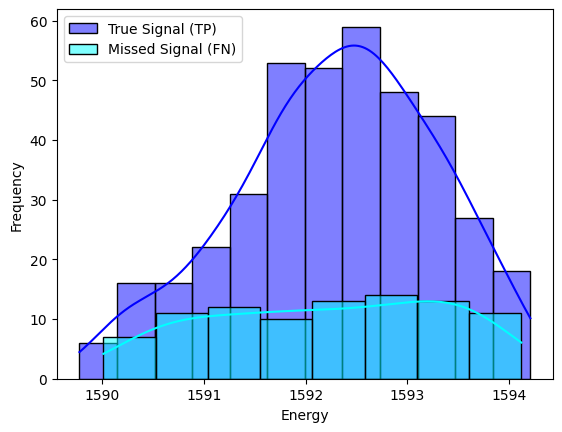

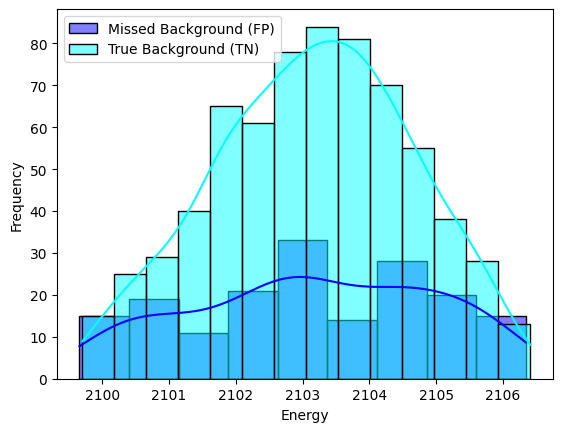

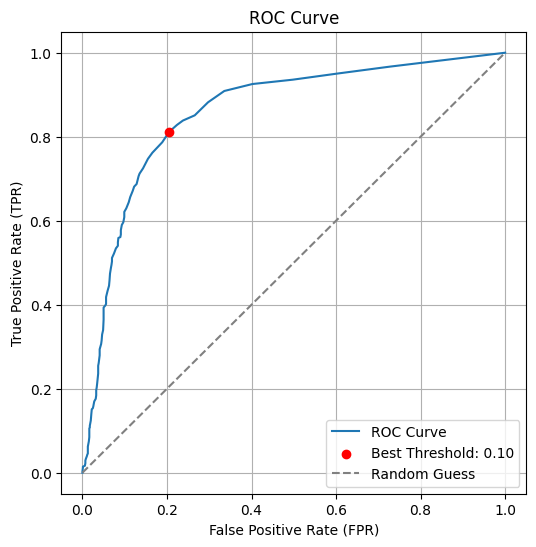

In [10]:
# determine your cutting threshold on detector A using both of its 1592 peak 
# (signal) and 2103 peak (background)
# perform baseline subtraction as needed

def threshold_calc(signal, background, name):
    tprs = []
    fprs = []
    
    best_tpr = 0
    best_fpr = 1
    best_threshold = 0
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        tp = np.sum((signal['class_score'] >= threshold))
        fp = np.sum((background['class_score'] >= threshold))
        fn = np.sum((signal['class_score'] < threshold))
        tn = np.sum((background['class_score'] < threshold))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tprs.append(tpr)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fprs.append(fpr)
        
        if tpr - fpr > best_tpr - best_fpr:
            best_tpr = tpr
            best_fpr = fpr
            best_threshold = threshold
    
    print(f"Detector {name} - Best Threshold: {best_threshold}, TPR: {best_tpr}, FPR: {best_fpr}")
    sns.histplot(signal[signal['class_score'] >= best_threshold]['energy'], color='blue', label='True Signal (TP)', kde=True)
    sns.histplot(signal[signal['class_score'] < best_threshold]['energy'], color='cyan', label='Missed Signal (FN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    sns.histplot(background[background['class_score'] >= best_threshold]['energy'], color='blue', label='Missed Background (FP)', kde=True)
    sns.histplot(background[background['class_score'] < best_threshold]['energy'], color='cyan', label='True Background (TN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_axisbelow(True)
    ax.plot(fprs, tprs, linestyle='-', label="ROC Curve")
    ax.scatter([best_fpr], [best_tpr], color='red', label=f'Best Threshold: {best_threshold:.2f}', zorder=5)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    ax.grid()
    plt.show()

    return best_threshold   

THRESHOLD = threshold_calc(true_A_signal_energy, true_A_background_energy, 'A')
# threshold_calc(detB, delta, 'B')

# 3. Evaluate and optimize cut against 2103 keV peak in detector B

Detector A, TPR: 0.8115942028985508, FPR: 0.20512820512820512


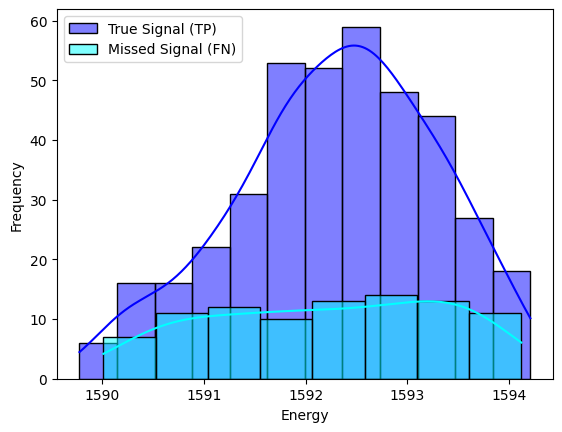

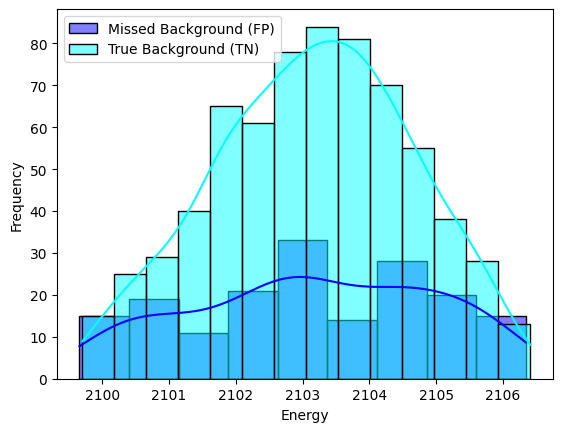

Detector B, TPR: 0.8053830227743272, FPR: 0.21839080459770116


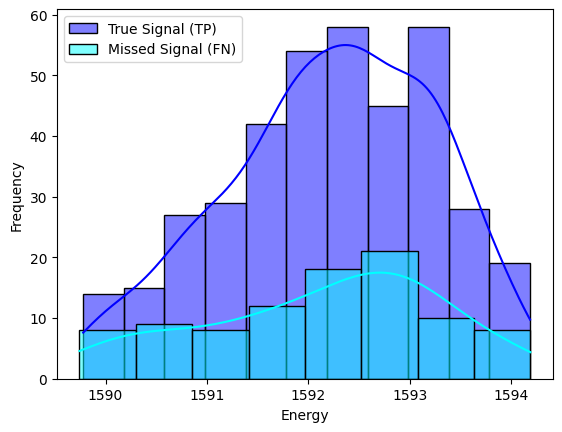

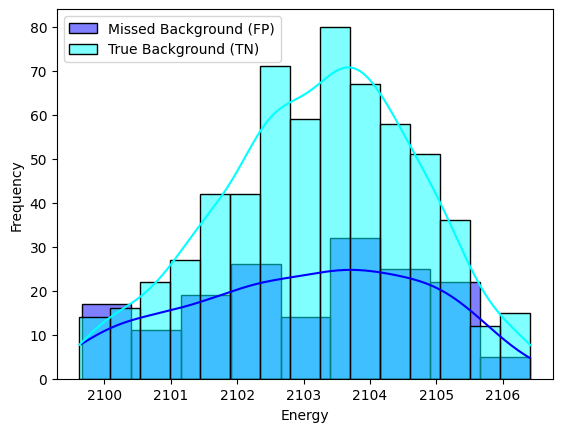

Detector C, TPR: 0.7750556792873051, FPR: 0.20204313280363223


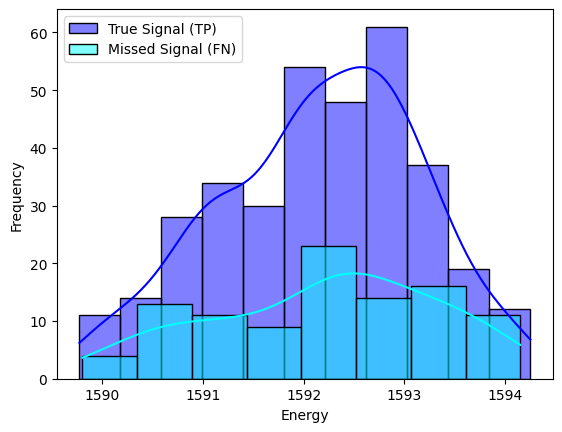

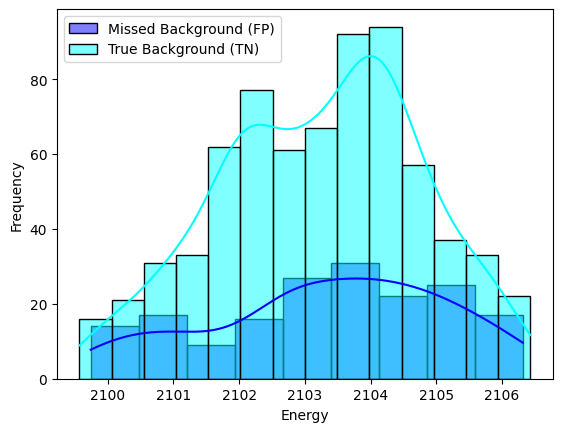

Detector Target, TPR: 0.8421052631578947, FPR: 0.20588235294117646


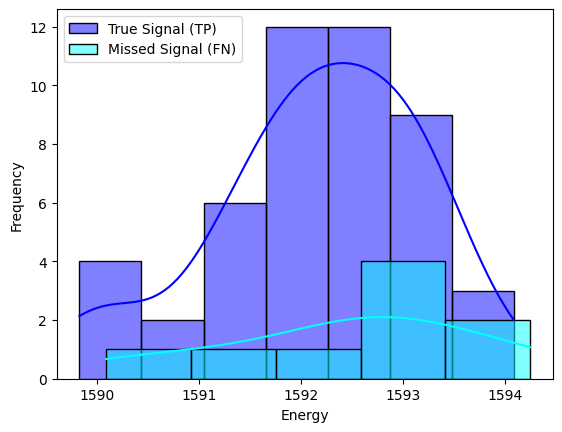

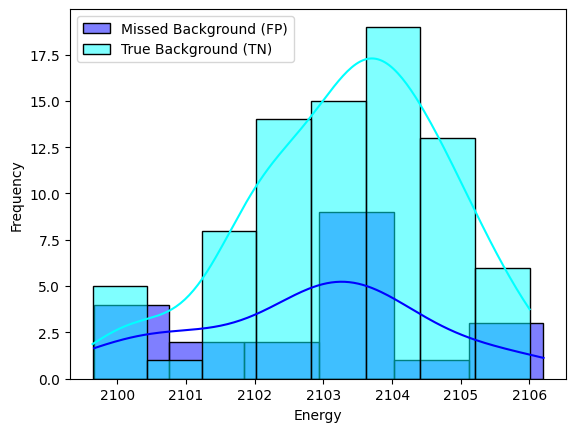

In [11]:
def eval_threshold(signal, background, threshold, name):
    tp = np.sum((signal['class_score'] >= threshold))
    fp = np.sum((background['class_score'] >= threshold))
    fn = np.sum((signal['class_score'] < threshold))
    tn = np.sum((background['class_score'] < threshold))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"Detector {name}, TPR: {tpr}, FPR: {fpr}")
    sns.histplot(signal[signal['class_score'] >= threshold]['energy'], color='blue', label='True Signal (TP)', kde=True)
    sns.histplot(signal[signal['class_score'] < threshold]['energy'], color='cyan', label='Missed Signal (FN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    sns.histplot(background[background['class_score'] >= threshold]['energy'], color='blue', label='Missed Background (FP)', kde=True)
    sns.histplot(background[background['class_score'] < threshold]['energy'], color='cyan', label='True Background (TN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

eval_threshold(true_A_signal_energy, true_A_background_energy, THRESHOLD, 'A')
eval_threshold(B_signal_energy, B_background_energy, THRESHOLD, 'B')
eval_threshold(C_signal_energy, C_background_energy, THRESHOLD, 'C')
eval_threshold(target_signal_energy, target_background_energy, THRESHOLD, 'Target')
    

# 4. Generate model PDF for NLDBD with peak at 2039 keV peak $\pm$1 
# 5. Apply cut and generate PDFs of detectors ABC and target histogram

In [12]:
### Generate PDF for each detector after cut
best_threshold = THRESHOLD
n_bins = 1000
energy_min = 1500
energy_max = 2200
n_bins = 1000  # adjust for resolution

### Applyign cut to all three detectors
detA_cut = detA[detA['class_score'] >= best_threshold]
detB_cut = detB[detB['class_score'] >= best_threshold]
detC_cut = detC[detC['class_score'] >= best_threshold]
detTarget_cut = detTarget[detTarget['class_score'] >= best_threshold]

detA_counts, bin_edges_A = np.histogram(detA_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
detB_counts, bin_edges_B = np.histogram(detB_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
detC_counts, bin_edges_C = np.histogram(detC_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
detTarget_counts, bin_edges_D = np.histogram(detTarget_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
bin_centers = 0.5 * (bin_edges_A[:-1] + bin_edges_A[1:])


In [13]:
# Bin width (same for all since bins are identical)
bin_width = bin_edges_A[1] - bin_edges_A[0]

# Convert counts → PDF
pdf_A = detA_counts / (detA_counts.sum() * bin_width)
pdf_B = detB_counts / (detB_counts.sum() * bin_width)
pdf_C = detC_counts / (detC_counts.sum() * bin_width)
# pdf_D = detTarget    / (detTarget.sum()    * bin_width)/


In [14]:
### Generate PDF for 0vbb

mu = 2039
sigma = 1
n_events = 10000

# Generate Monte Carlo NLDBD events
events = np.random.normal(loc=mu, scale=sigma, size=n_events)

# Use EXACT SAME BINS as your detectors
bins = bin_edges_A
bin_width = bins[1] - bins[0]

# Histogram using the same bins
counts_ovbb, _ = np.histogram(events, bins=bins)

# Normalize to PDF
pdf_ovbb = counts_ovbb / (np.sum(counts_ovbb) * bin_width)

In [15]:
import numpy as np

np.savez(
    "./data/energy_pdfs.npz",
    bin_edges=bin_edges_A,
    bin_centers=bin_centers,
    pdf_A=pdf_A,
    pdf_B=pdf_B,
    pdf_C=pdf_C,
    pdf_ovbb=pdf_ovbb,
    counts_Target=detTarget_counts,  # add Target histogram counts here
)

print("Saved to energy_pdfs.npz")


Saved to energy_pdfs.npz


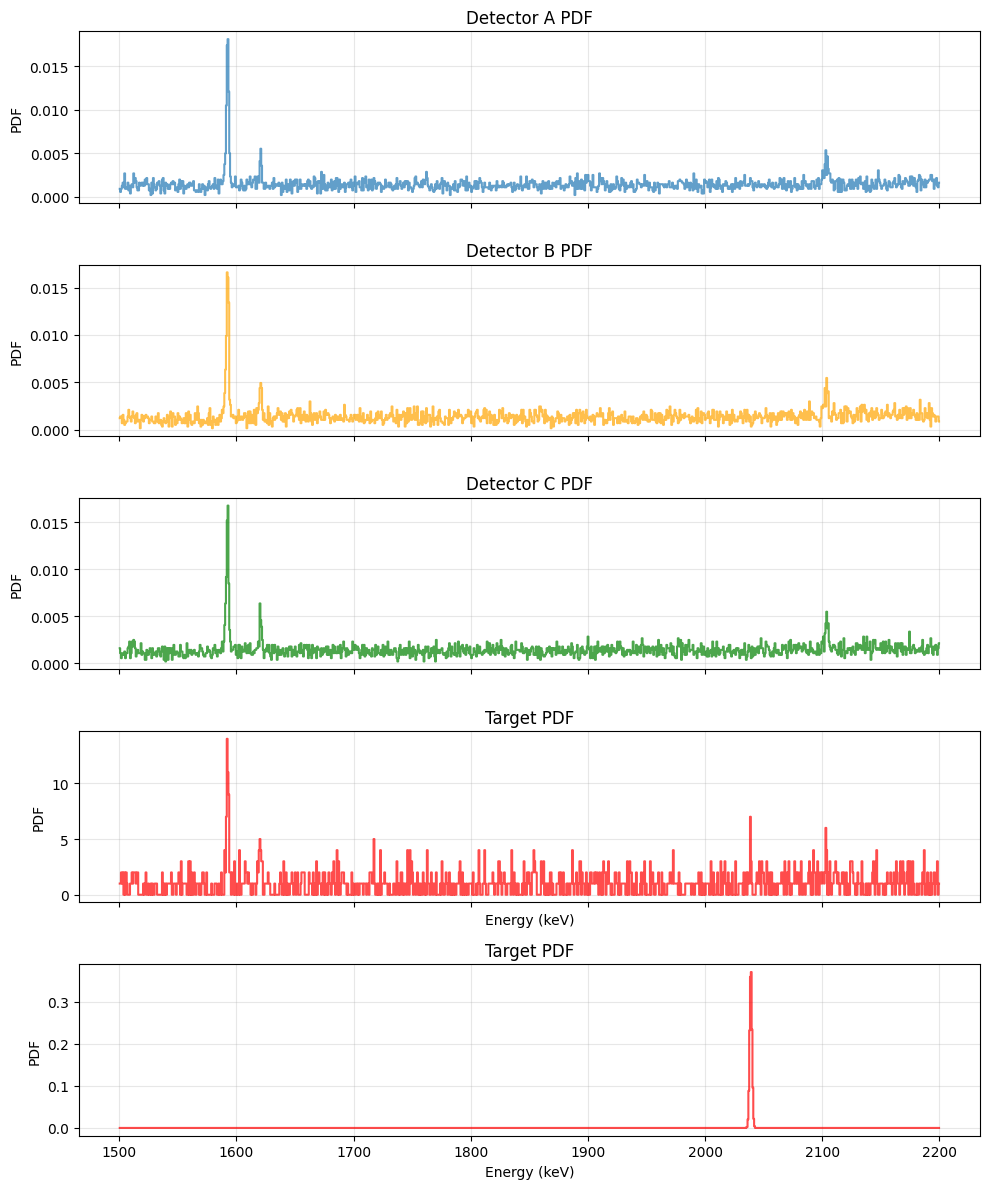

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Detector A
axs[0].step(bin_centers, pdf_A, where='mid', alpha=0.7)
axs[0].set_ylabel("PDF")
axs[0].set_title("Detector A PDF")
axs[0].grid(alpha=0.3)

# Detector B
axs[1].step(bin_centers, pdf_B, where='mid', alpha=0.7, color='orange')
axs[1].set_ylabel("PDF")
axs[1].set_title("Detector B PDF")
axs[1].grid(alpha=0.3)

# Detector C
axs[2].step(bin_centers, pdf_C, where='mid', alpha=0.7, color='green')
axs[2].set_ylabel("PDF")
axs[2].set_title("Detector C PDF")
axs[2].grid(alpha=0.3)

# Target
axs[3].step(bin_centers, detTarget_counts,
            where='mid', alpha=0.7, color='red')
axs[3].set_ylabel("PDF")
axs[3].set_title("Target PDF")
axs[3].set_xlabel("Energy (keV)")
axs[3].grid(alpha=0.3)

# ovbb
axs[4].step(bin_centers, pdf_ovbb,
            where='mid', alpha=0.7, color='red')
axs[4].set_ylabel("PDF")
axs[4].set_title("Target PDF")
axs[4].set_xlabel("Energy (keV)")
axs[4].grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 6. Using Bayesian Methods to fit PDF

In [17]:
data = np.load("./data/energy_pdfs.npz")
pdf_A = data['pdf_A']
pdf_B  = data['pdf_B']
pdf_C = data['pdf_C']
pdf_ovbb = data['pdf_ovbb']
bin_edges = data['bin_edges']
bin_centers = data['bin_centers']
counts_Target = data['counts_Target']

In [18]:
mu_nl = 2039.0
sigma_nl = 1.0

pdf_A = pdf_A / np.sum(pdf_A)
pdf_B = pdf_B / np.sum(pdf_B)
pdf_C = pdf_C / np.sum(pdf_C)
pdf_ovbb = pdf_ovbb / np.sum(pdf_ovbb)

In [19]:
nbins = len(bin_centers)
N_obs = counts_Target.sum()
bin_width = (bin_centers[1] - bin_centers[0])

def expected_counts(theta):
    thetaA, thetaB, thetaC, thetaNL = theta
    mu = thetaA * pdf_A + thetaB * pdf_B + thetaC * pdf_C + thetaNL * pdf_ovbb
    return mu

In [20]:
thetaA_mean, thetaA_sigma = 1350.0, 100.0
thetaB_mean, thetaB_sigma = 770.0, 270.0
sigma_C = 2000.0
sigma_NL = 2000.0

In [21]:
def log_prior(theta):
    thetaA, thetaB, thetaC, thetaNL = theta
    if thetaA < 0 or thetaB < 0 or thetaC < 0 or thetaNL < 0:
        return -np.inf

    # Gaussian log-priors for A and B
    lp = -0.5 * ((thetaA - thetaA_mean) / thetaA_sigma) ** 2 - np.log(thetaA_sigma * np.sqrt(2*np.pi))
    lp += -0.5 * ((thetaB - thetaB_mean) / thetaB_sigma) ** 2 - np.log(thetaB_sigma * np.sqrt(2*np.pi))

    # half-normal (x>=0) log-prior for C and NL: density = sqrt(2)/(sigma*sqrt(pi)) * exp(-x^2/(2 sigma^2))
    lp += np.log(np.sqrt(2/(np.pi))) - np.log(sigma_C) - 0.5 * (thetaC / sigma_C) ** 2
    lp += np.log(np.sqrt(2/(np.pi))) - np.log(sigma_NL) - 0.5 * (thetaNL / sigma_NL) ** 2

    return lp

In [22]:
def log_likelihood(theta):
    mu = expected_counts(theta)
    mu = np.clip(mu, 1e-12, None)
    k = counts_Target
    return np.sum(k * np.log(mu) - mu)

In [23]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    return lp + ll

In [24]:
ndim = 4
nwalkers = 50
rng = np.random.default_rng(24352)
init_theta = np.array([thetaA_mean, thetaB_mean, 500.0, 500.0])
p0 = init_theta + init_theta * 0.05 * rng.standard_normal((nwalkers, ndim))
p0 = np.clip(p0, 1e-6, None)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
print("Running burn-in...")
pos, prob, state = sampler.run_mcmc(p0, 1500, progress=True)
sampler.reset()
print("Running main sampling...")
sampler.run_mcmc(pos, 3000, progress=True)

samples = sampler.get_chain(flat=True)
print("Samples shape:", samples.shape)

names = ["thetaA", "thetaB", "thetaC", "thetaNL"]
import numpy as np
def summarize(arr, name):
    med = np.percentile(arr, 50)
    lo = np.percentile(arr, 16)
    hi = np.percentile(arr, 84)
    p90 = np.percentile(arr, 90)
    print(f"{name}: median={med:.2f}, -{med-lo:.2f}/+{hi-med:.2f}, 90pct={p90:.2f}")
    return med, lo, hi, p90

for i, n in enumerate(names):
    summarize(samples[:, i], n)

Running burn-in...


100%|██████████| 1500/1500 [00:01<00:00, 855.03it/s]


Running main sampling...


100%|██████████| 3000/3000 [00:03<00:00, 857.81it/s]

Samples shape: (150000, 4)
thetaA: median=642.83, -60.14/+61.17, 90pct=721.33
thetaB: median=328.06, -62.41/+61.10, 90pct=406.91
thetaC: median=76.38, -47.89/+61.90, 90pct=157.14
thetaNL: median=8.68, -3.39/+4.10, 90pct=14.04


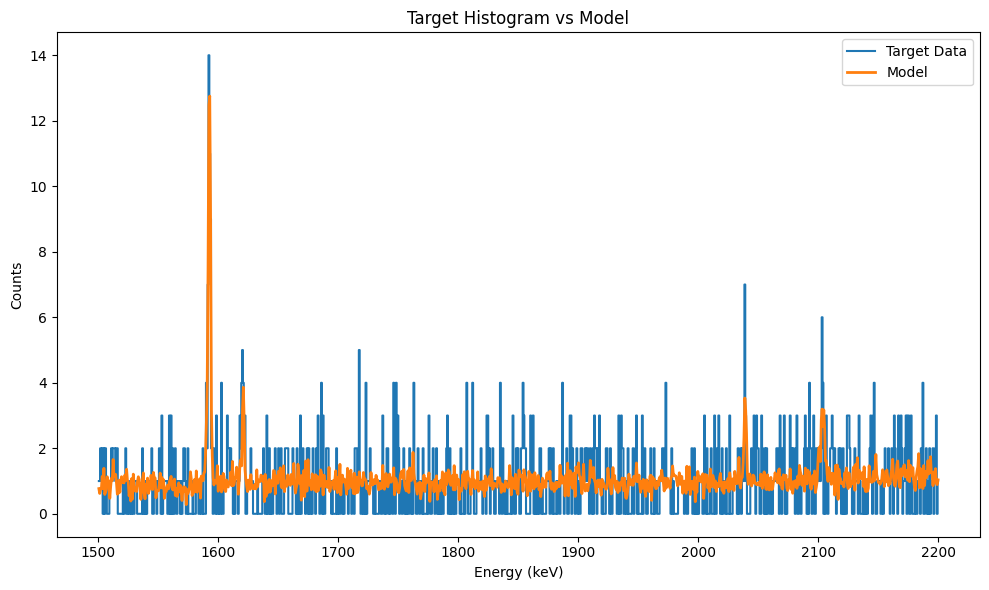

In [25]:
thetaA_med, thetaB_med, thetaC_med, thetaNL_med = np.median(samples, axis=0)
model_counts = (
    thetaA_med * pdf_A +
    thetaB_med * pdf_B +
    thetaC_med * pdf_C +
    thetaNL_med * pdf_ovbb
)
plt.figure(figsize=(10,6))
plt.step(bin_centers, counts_Target, where="mid", label="Target Data", linewidth=1.5)
plt.plot(bin_centers, model_counts, label="Model", linewidth=2)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Target Histogram vs Model")
plt.legend()
plt.tight_layout()
plt.show()

# 5b. Frequentist Fit

In [26]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges):
    """
    Fit DetectorTarget histogram with template PDFs and show uncertainties.
    """
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Model chi2 function
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A + theta_B * pdf_B + theta_C * pdf_C + theta_ovbb * pdf_ovbb)
        return np.sum((counts_Target - model)**2 / (model + 1e-6))  # avoid div0

    # Initial guess
    m = Minuit(chi2, theta_A=500, theta_B=300, theta_C=100, theta_ovbb=10)
    m.errordef = 1  # chi2
    m.limits = [(0, None), (0, None), (0, None), (0, None)]
    m.migrad()

    # Extract fit values and errors
    theta_fit = m.values
    theta_err = m.errors

    print("Fitted θ values ± 1σ:")
    for i, name in enumerate(['theta_A', 'theta_B', 'theta_C', 'theta_ovbb']):
        print(f"{name} = {theta_fit[i]:.2f} ± {theta_err[i]:.2f}")

    # Model counts
    model_counts = (theta_fit['theta_A']*pdf_A +
                    theta_fit['theta_B']*pdf_B +
                    theta_fit['theta_C']*pdf_C +
                    theta_fit['theta_ovbb']*pdf_ovbb)

    # Setup figure with ratio subplot
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    # Main histogram
    ax_main.bar(bin_centers, counts_Target, width=bin_width, color='gray', alpha=0.6, label='Data')
    ax_main.step(bin_centers, model_counts, color='red', where='mid', label='Fit')
    ax_main.set_ylabel("Counts / bin")
    ax_main.set_title("DetectorTarget Fit with Template PDFs")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # Ratio plot
    mask = counts_Target > 2  # ignore bins with less than 2 counts
    ratio = model_counts[mask] / counts_Target[mask]
    ax_ratio.step(bin_centers[mask], ratio, color='blue', where='mid')
    ax_ratio.axhline(1, color='black', linestyle='--')
    ax_ratio.set_xlabel("Energy (keV)")
    ax_ratio.set_ylabel("Fit / Data")
    ax_ratio.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return theta_fit, theta_err


# 7. Calculate 90% confidence interval

In [27]:
### Confidence level

from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb):
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A +
                 theta_B * pdf_B +
                 theta_C * pdf_C +
                 theta_ovbb * pdf_ovbb)
        return np.sum((counts - model)**2 / (model + 1e-6))
    return chi2

def profile_ci_ovbb(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb,
                    best_fit, n_scan=80, max_val=20):
    """
    Compute profile chi2 for theta_ovbb and return 90% CL.
    """
    chi2_fn = chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb)

    theta_ovbb_values = np.linspace(0, max_val, n_scan)
    chi2_profile = []

    for theta_ovbb in theta_ovbb_values:
        def chi(theta_A, theta_B, theta_C):
            return chi2_fn(theta_A, theta_B, theta_C, theta_ovbb)
        m = Minuit(chi,
                   theta_A=best_fit["theta_A"],
                   theta_B=best_fit["theta_B"],
                   theta_C=best_fit["theta_C"],
            )

        m.errordef = 1
        m.limits = [(0,None),(0,None),(0,None)]
        m.migrad()

        chi2_profile.append(m.fval)

    chi2_profile = np.array(chi2_profile)

    # best chi2
    chi2_min = np.min(chi2_profile)

    # 90% CL threshold
    delta90 = chi2_min + 2.71

    # Find CI region
    mask = chi2_profile <= delta90
    ci_low = theta_ovbb_values[mask][0]
    ci_high = theta_ovbb_values[mask][-1]

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(theta_ovbb_values, chi2_profile, '-o', markersize=3)
    plt.axhline(chi2_min, linestyle='--', color='black', label='best fit')
    plt.axhline(delta90, linestyle='--', color='red', label='90% CL')
    plt.xlabel("theta_ovbb")
    plt.ylabel("chi2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"90% CL interval for θ_ovbb: [{ci_low:.2f}, {ci_high:.2f}]")

    return ci_low, ci_high, theta_ovbb_values, chi2_profile


Fitted θ values ± 1σ:
theta_A = 410.92 ± 89.00
theta_B = 591.65 ± 84.94
theta_C = 426.09 ± 87.46
theta_ovbb = 10.20 ± 4.05


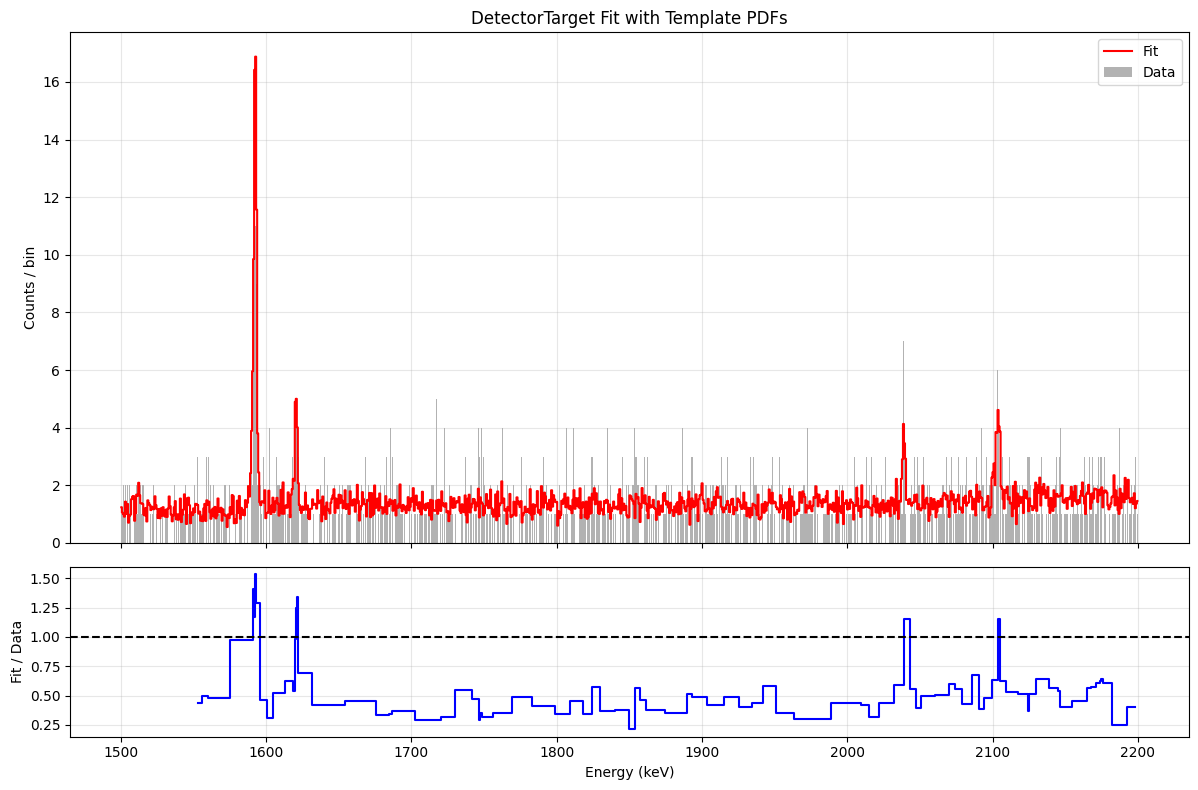

In [29]:
theta_fit, theta_error = fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges)

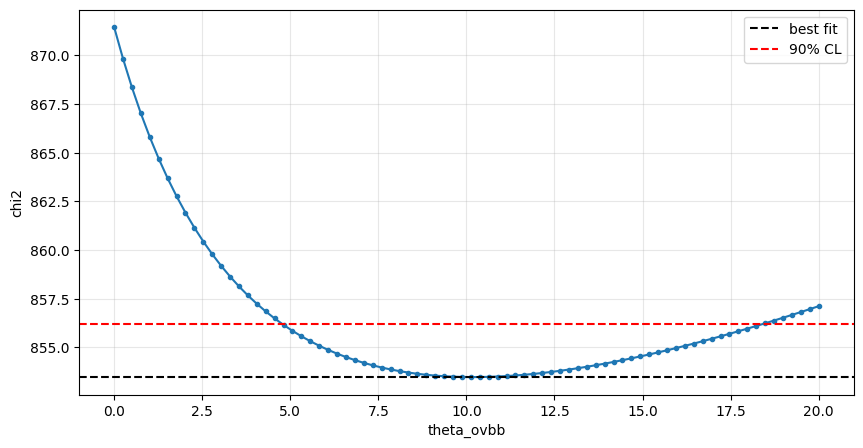

90% CL interval for θ_ovbb: [4.81, 18.23]


In [30]:
ci_low, ci_high, scan_x, scan_chi2 = profile_ci_ovbb(
    counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, theta_fit
)


# 8. Calculate Experimental Sensativity

In [33]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb):
    """Return a chi2 function for the template fit"""
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A + theta_B * pdf_B + theta_C * pdf_C + theta_ovbb * pdf_ovbb)
        return np.sum((counts - model)**2 / (model + 1e-6))  # avoid div0
    return chi2

def profile_upper_limit(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb,
                        best_fit, n_scan=80, max_val=20):
    """
    Profile chi2 for theta_ovbb (thetaNLDBD) and return 90% CL upper limit.
    """
    chi2_fn = chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb)
    theta_ovbb_values = np.linspace(0, max_val, n_scan)
    chi2_profile = []

    for theta_ovbb in theta_ovbb_values:
        def chi(theta_A, theta_B, theta_C):
            return chi2_fn(theta_A, theta_B, theta_C, theta_ovbb)
        m = Minuit(chi,
                   theta_A=best_fit["theta_A"],
                   theta_B=best_fit["theta_B"],
                   theta_C=best_fit["theta_C"])
        m.errordef = 1
        m.limits = [(0,None),(0,None),(0,None)]
        m.migrad()
        chi2_profile.append(m.fval)

    chi2_profile = np.array(chi2_profile)
    chi2_min = np.min(chi2_profile)
    delta90 = chi2_min + 2.71  # 90% CL for one parameter

    # Upper limit is the largest theta_ovbb below the 90% CL threshold
    mask = chi2_profile <= delta90
    upper_limit = theta_ovbb_values[mask][-1]

    return upper_limit

def compute_sensitivity(n_toys, counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, best_fit):
    """
    Compute the experimental sensitivity (median upper limit) using pseudo-experiments.
    """
    upper_limits = []
    total_counts = best_fit["theta_A"]*pdf_A + best_fit["theta_B"]*pdf_B + best_fit["theta_C"]*pdf_C

    for i in range(n_toys):
        # Generate pseudo-data with Poisson fluctuations under null hypothesis (theta_ovbb=0)
        toy_counts = np.random.poisson(total_counts)
        ul = profile_upper_limit(toy_counts, pdf_A, pdf_B, pdf_C, pdf_ovbb, best_fit)
        upper_limits.append(ul)

    upper_limits = np.array(upper_limits)
    median_sensitivity = np.median(upper_limits)

    # Plot
    plt.figure(figsize=(10,5))
    plt.hist(upper_limits, bins=50, alpha=0.7, color='skyblue')
    plt.axvline(median_sensitivity, color='red', linestyle='--', label='Median Sensitivity')
    plt.xlabel('θNLDBD upper limit at 90% CL')
    plt.ylabel('Number of toys')
    plt.title('Experimental Sensitivity Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Median 90% CL upper limit (experimental sensitivity): {median_sensitivity:.2f}")

    return upper_limits, median_sensitivity


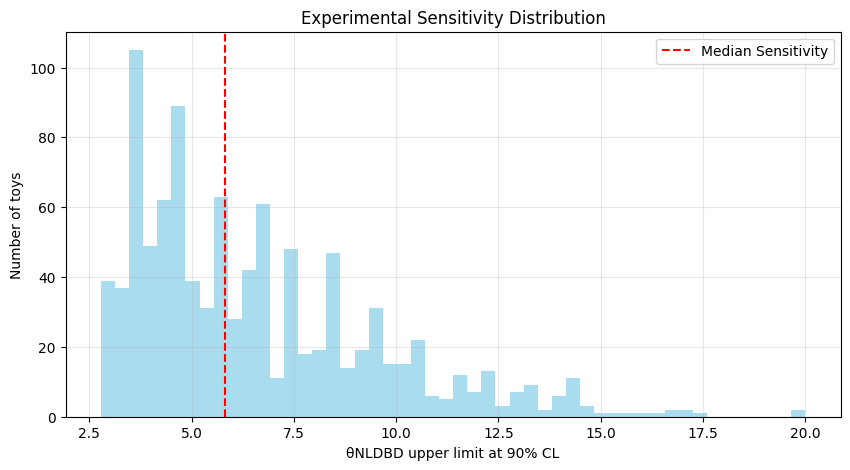

Median 90% CL upper limit (experimental sensitivity): 5.82


In [35]:
n_toys = 1000  # or 1000 for more precise result
upper_limits, median_sens = compute_sensitivity(n_toys,
                                                counts_Target,
                                                pdf_A, pdf_B, pdf_C, pdf_ovbb,
                                                theta_fit)

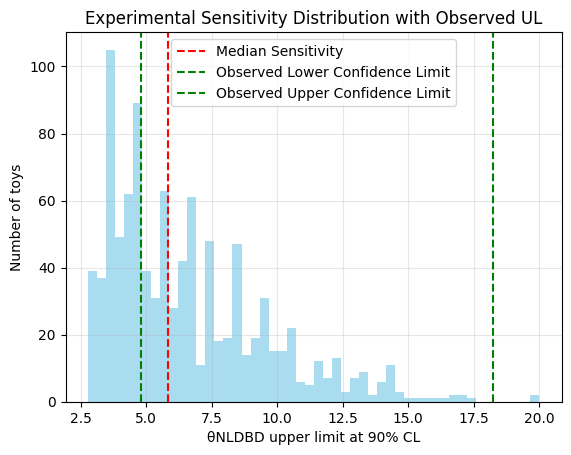

In [36]:
plt.hist(upper_limits, bins=50, alpha=0.7, color='skyblue')
plt.axvline(median_sens, color='red', linestyle='--', label='Median Sensitivity')
plt.axvline(ci_low, color='green', linestyle='--', label='Observed Lower Confidence Limit')
plt.axvline(ci_high, color='green', linestyle='--', label='Observed Upper Confidence Limit')
plt.xlabel('θNLDBD upper limit at 90% CL')
plt.ylabel('Number of toys')
plt.title('Experimental Sensitivity Distribution with Observed UL')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
